In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


%config InlineBackend.figure_format = 'retina'

# fix type3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
#
# READ DATA
#

prefixes = [
    "20231107-0917-pudding", 
]
rounds = [1, 2, ]

user_nums = [20, ]
server_nums = [4, 7, 10, ]
scenarios = ["register", "lookup_anonymous", "lookup_identity"]
metrics = ["REGISTER", "LOOKUP", "ADDFRIEND"]


def read_file(user_num, server_num, scenario, round):
    types, latencies = [], []

    def extract_latency(line):
        return float(line.split(" ")[-1]) / 1000.0

    filename = f"../output/{prefix}-{scenario}-u{user_num}-s{server_num}-r{round}.log"

    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        return pd.DataFrame({'u': [], 's': [], 'scenario': [], 'type': [], 'latency': []})

    with open(filename, "r") as f:
        for line in f.readlines():
            for metric in metrics:
                if metric in line:
                    types.append(metric)
                    latencies.append(extract_latency(line))
                    break

    return pd.DataFrame({'u': user_num, 's': server_num, 'scenario': scenario, 'type': types, 'latency': latencies})


dfs = []
for scenario in scenarios:
    for user_num in user_nums:
        for server_num in server_nums:
            for prefix in prefixes:
                for round in rounds:
                    dfs.append(read_file(user_num, server_num, scenario, round))

df = pd.concat(dfs, ignore_index=True)
del dfs

# Optional: export as compressed .csv file
# df.to_csv("data.csv.gz", index=False, compression="gzip")

df

u   s         scenario       type  latency
0      20   4         register   REGISTER    6.982
1      20   4         register   REGISTER    4.166
2      20   4         register   REGISTER    5.238
3      20   4         register   REGISTER    6.631
4      20   4         register   REGISTER    6.870
...    ..  ..              ...        ...      ...
10536  20  10  lookup_identity     LOOKUP    1.844
10537  20  10  lookup_identity  ADDFRIEND    4.618
10538  20  10  lookup_identity     LOOKUP    3.267
10539  20  10  lookup_identity  ADDFRIEND    5.882
10540  20  10  lookup_identity     LOOKUP    1.684

[10541 rows x 5 columns]

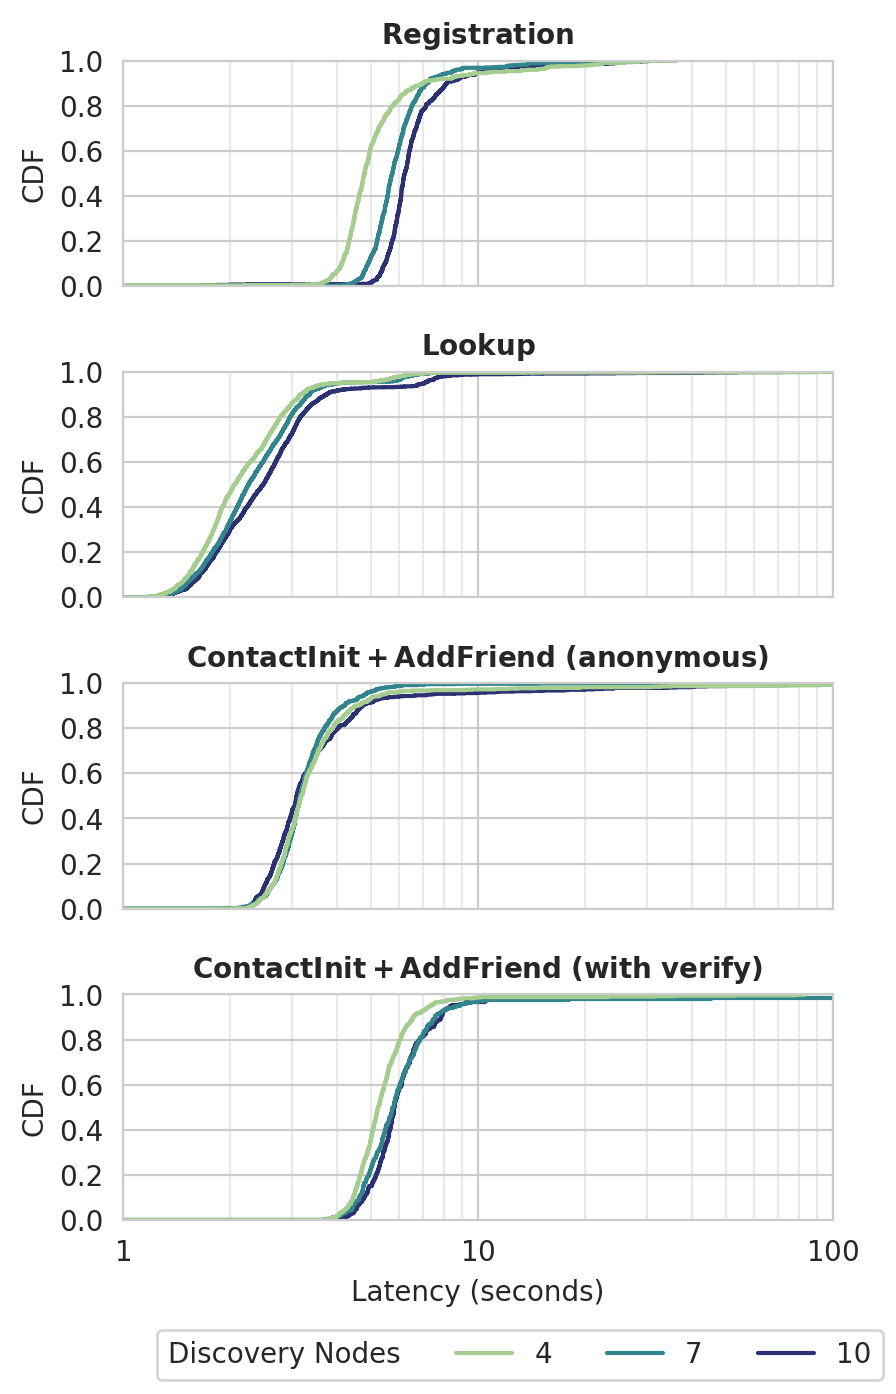

In [3]:
#
# PLOT
#

sns.set_style("whitegrid")

fig, (ax1, ax2, ax3, ax4,) = plt.subplots(4, 1, sharex="all", sharey="all")
fig.set_size_inches(4.5, 7)


def plot_ecdf(ax, data, title, xlabel=None, legend=False):
    sns.ecdfplot(
        data=data,
        x="latency",
        hue="s",
        log_scale=True,
        ax=ax,
        legend=legend,
        palette="crest",
    )
    if title:
        ax.set_title(
            r"$\bf{" + title + "}$",# + f" (n={len(data)})",
            fontdict={'fontsize': 10, 'fontweight': 'medium'}
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel("CDF")

    ax.set_yticks(np.arange(0, 1.1, 0.2))

    ax.set_xlim(1, 100)
    ax.set_xticks([1, 10, 100])
    ax.set_xticklabels(["$1$", "$10$", "$100$"])

    # Manually adding minor ticks...
    ax.set_xticks([2, 3, 4, 5, 6, 7, 8, 9, 20, 30, 40, 50, 60, 70, 80, 90], minor=True)
    ax.grid(which='major', axis="x", alpha=1)
    ax.grid(which='minor', axis="x", alpha=0.4)


plot_ecdf(
    ax=ax1,
    data=df[(df.scenario == "register") & (df.type == "REGISTER")],
    title="Registration",
)

plot_ecdf(
    ax=ax2,
    data=df[(df.type == "LOOKUP")],
    title="Lookup",
)

plot_ecdf(
    ax=ax3,
    data=df[(df.scenario == "lookup_anonymous") & (df.type == "ADDFRIEND")],
    title="ContactInit + AddFriend~(anonymous)",
)

plot_ecdf(
    ax=ax4,
    data=df[(df.scenario == "lookup_identity") & (df.type == "ADDFRIEND")],
    title="ContactInit + AddFriend~(with~verify)",
    xlabel="Latency (seconds)",
    legend=True
)


fig.tight_layout()
fig.subplots_adjust(bottom=0.12)  # make room for legend


def legend_title_left(leg):
    # src: https://stackoverflow.com/questions/53316999/pyplot-legend-left-alignment-of-a-title
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()


legend = fig.legend(
    handles=ax4.get_legend().legend_handles,
    labels=["4", "7", "10"],
    loc="lower right",
    ncol=4,
    title="Discovery Nodes"
)
legend_title_left(legend)
ax4.get_legend().remove()

fig.savefig("figures/latencies.pdf", bbox_inches='tight')


In [4]:
#
# TABLE
#


def print_rows(title, data):
    print("\\multicolumn{5}{c}{\\textit{" + title + "}}\\\\")
    print("\\midrule")
    for server_num in server_nums:
        d = data[data.s == server_num].latency
        mean = d.mean()
        p50 = d.quantile(0.5)
        p90 = d.quantile(0.9)
        p95 = d.quantile(0.95)

        print(
            "{:d} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(
                server_num, mean, p50, p90, p95
            )
        )


print_rows(
    title="Registration",
    data=df[(df.scenario == "register") & (df.type == "REGISTER")],
)
print("\midrule")
print_rows(
    title="Lookup",
    data=df[(df.type == "LOOKUP")],
)
print("\midrule")
print_rows(
    title="ContactInit + AddFriend (anonymous)",
    data=df[(df.scenario == "lookup_anonymous") & (df.type == "ADDFRIEND")],
)
print("\midrule")
print_rows(
    title="ContactInit + AddFriend (with verify)",
    data=df[(df.scenario == "lookup_identity") & (df.type == "ADDFRIEND")],
)


\multicolumn{5}{c}{\textit{Registration}}\\
\midrule
4 & 5.74 & 4.79 & 6.98 & 11.02 \\
7 & 6.15 & 5.74 & 7.16 & 8.46 \\
10 & 6.96 & 6.23 & 8.17 & 10.35 \\
\midrule
\multicolumn{5}{c}{\textit{Lookup}}\\
\midrule
4 & 2.53 & 2.06 & 3.17 & 4.01 \\
7 & 2.51 & 2.25 & 3.35 & 4.06 \\
10 & 3.08 & 2.49 & 3.76 & 7.06 \\
\midrule
\multicolumn{5}{c}{\textit{ContactInit + AddFriend (anonymous)}}\\
\midrule
4 & 4.83 & 3.18 & 4.53 & 5.36 \\
7 & 3.38 & 3.16 & 4.20 & 4.81 \\
10 & 5.47 & 3.08 & 4.73 & 7.27 \\
\midrule
\multicolumn{5}{c}{\textit{ContactInit + AddFriend (with verify)}}\\
\midrule
4 & 5.92 & 5.24 & 6.58 & 7.37 \\
7 & 9.15 & 5.78 & 7.59 & 8.80 \\
10 & 6.20 & 5.82 & 7.89 & 8.40 \\
